# Aula 16

Nas últimas aulas resolvemos o problema de movimento do pêndulo utilizando o método de Euler. Porém, como vimos, o método de Euler não é muito preciso, e o erro propagado ao longo da integração é muito grande. Para diminuir este problema, utilizamos passos muito pequenos e um intervalo curto de integração.

Porém, existem ferramentas já disponibilizadas que permitem a realização de uma integração numérica por um intervalo muito maior de tempo com menor propagação de erro. Uma delas é o módulo **inegrate** do pacoto **scipy**. Normalmente o scipy já vem instalado com o python, mas caso este não seja o caso, basta utilizar o comando abaixo:

```bash
pip install scipy
```

O módulo integrate do scipy possui diversas funções para realizar integrações numéricas. Dêem uma olhada em sua documentação: https://docs.scipy.org/doc/scipy/tutorial/integrate.html

Destes, iremos utilizar a função **solve\_ivp**: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

Para aprendermos a utilizá-la, vamos integrar novamente o movimento do pêndulo.

In [1]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Primeiramente definimos os valores das constantes que serão utilizadas no problema
g = 9.81  # m/s²
L = 5  # m
m = 40  #kg

In [3]:
# Definimos a função que calcula as derivadas do movimento do pêndulo
# Note que agora a função precisa receber como primeiro parâmetro o tempo, mesmo que a gente não o use,
# e o segundo parâmetro será uma lista com os valores iniciais.
# Isto é a forma como o solve_ivp trabalha. Outras funções ou outros pacotes
# podem fazer as coisas de formas diferentes.
def pendulo(t, y):
    """ Calcula as derivadas do movimento do pêndulo com resistência do ar: Eq. 4 da Aula 12
    
    Parameters
    ----------
    t : float
        Tempo
    y : list
        Lista com dois valores, o ângulo e a velocidade angular.
    """
    # Agora precisamos separar os valores da lista em variáveis correspondentes
    theta = y[0]
    w = y[1]
    
    dthetadt = w  # A derivada de theta em relação ao tempo
    dwdt = -(g/L)*np.sin(theta) # A derivada de omega em relação ao tempo desconsiderando resistência do ar
    
    # Agora devemos retornar uma lista com todas as derivadas
    return [dthetadt, dwdt]

In [4]:
t_span = [0, 50]  # Precisamos definir uma lista com dois elementos: t0 e tf.
v0 = [60*np.pi/180, 0]  # Definimos a lista de condições iniciais.
sol1 = solve_ivp(pendulo, t_span, v0)  # executamos o solve_ivp passando os parâmetros necessários.

In [5]:
print(sol1)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.880e-04 ...  4.969e+01  5.000e+01]
        y: [[ 1.047e+00  1.047e+00 ... -5.915e-01 -8.742e-01]
            [ 0.000e+00 -9.990e-04 ... -1.106e+00 -6.950e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 566
     njev: 0
      nlu: 0


In [6]:
t = sol1.t  # Pegamos a lista de instantes de tempo, criada pelo próprio solve_ivp
theta = sol1.y[0]  # Pegamos a lista de valores de theta
w = sol1.y[1]  # Pegamos a lista de valores da velocidade angular

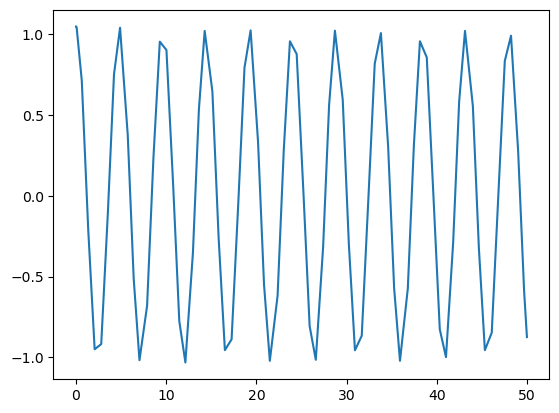

In [7]:
plt.plot(t, theta)

In [8]:
# Verificamos a solução utilizando a energia
K = (m*(L*w)**2)/2
U = m*g*L*(1-np.cos(theta))
E = K + U

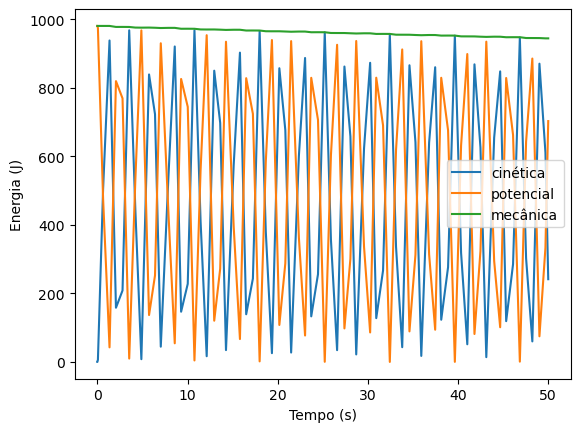

In [9]:
plt.plot(t, K, label='cinética')
plt.plot(t, U, label='potencial')
plt.plot(t, E, label='mecânica')
plt.xlabel('Tempo (s)')
plt.ylabel('Energia (J)')
plt.legend()

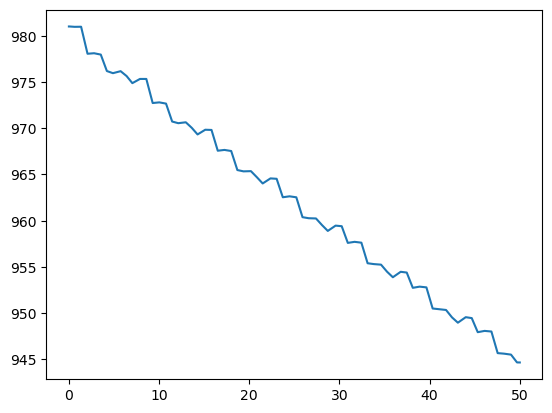

In [10]:
plt.plot(t, E)

Note que a energia mecânica está variando significativamente ao longo da integração, mostrando que a integração não está sendo realizada de forma adequada. Isso se deve à função **solve_ivp** não permitir que o usuário defina o passo da integração. Podemos, no entanto, fornecer um passo máximo, assim controlando um pouco mais a integração.

In [11]:
t_span = [0,1000]  # Vamos fazer agora a integração ao longo de mil segundos.
sol2 = solve_ivp(pendulo, t_span, v0, method='RK45', max_step=0.01)

In [12]:
t2 = sol2.t
theta2 = sol2.y[0]
w2 = sol2.y[1]

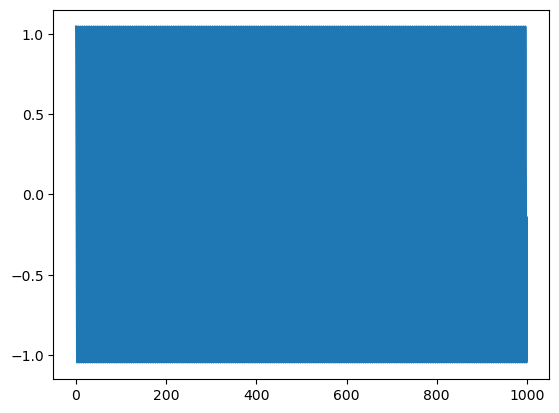

In [13]:
plt.plot(t2, theta2)

In [14]:
# Verificamos a energia
K2 = (m*(L*w2)**2)/2
U2 = m*g*L*(1-np.cos(theta2))
E2 = K2 + U2

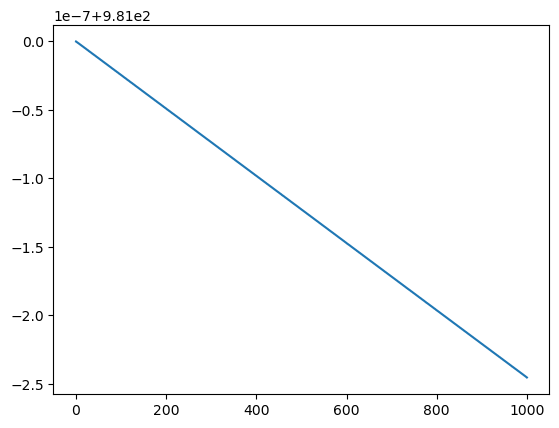

In [15]:
#plt.plot(t, E)
plt.plot(t2, E2)

In [16]:
print((E2[0] - E2[-1])/E[0])

2.502521954527387e-10


Limitando o passo, mesmo sendo um passo maior que o utilizando com o método de Euler, e integrando por mil segundos, a energia variou muito pouco, 0.00000002%. Ou seja, provê um resultado confiável.

## Movimento de Dois Corpos

Agora que sabemos utilizar o solve_ivp, vamos realizar a integração de um problema diferente, o movimento planetário de dois corpos.

Suponha dois corpos, com massas $m_1$ e $m_2$ no espaço como mostrado na figura abaixo. A posição deles em relação a um referencial inercial é $\vec{r}_1$ e $\vec{r}_2$, sendo a posição do corpo 2 em relação ao corpo 1 dado pelo vetor $\vec{r} = \vec{r}_2 - \vec{r}_1$.

![Movimendo de dois corpo](figuras/2-body-system.png)

Se procurarmos descrever o movimento do corpo 2, a única força atuando será a força gravitacional do corpo 1. Esta força terá a direção do corpo 2 para o corpo 1, já que é uma força atrativa. Sendo assim, utilizando a segunda lei de Newton, a aceleração do corpo 2 será:

$$m_2\vec{a}_2 = -\frac{Gm_1m_2}{r^2}\hat{r}$$

Onde $\hat{r}$ denota que a direção da força está na direção do vetor $\vec{r}$ e o sinal negativo indica que o sentido da força está no sentido oposto a $\hat{r}$. Simplificando, obtemos:

$$\vec{a}_2 = -\frac{Gm_1}{r^3}\vec{r}$$

Fazendo a mesma conta para obter a acelaração do objeto $m_2$, e separando em coordenadas  para um movimento apenas no plano x,y, temos:

$$a_{1x} = \frac{Gm_2}{r^3}(x_2 - x_1)$$
$$a_{1y} = \frac{Gm_2}{r^3}(y_2 - y_1)$$
$$a_{2x} = -\frac{Gm_1}{r^3}(x_2 - x_1)$$
$$a_{2y} = -\frac{Gm_1}{r^3}(y_2 - y_1)$$

Para implementar essas equações na integração, precisamos notar que a aceleração é a segunda derivada da posição. Sendo uma equação diferencial ordinária de segunda ordem precisamos fornecer as posições e velocidades iniciais como condições iniciais do problema. Assim, para as posições, precisamos retornar suas derivadas, que são as velocidades, e para as velocidades precisamos retornar suas derivadas, que são as acelerações.

In [17]:
# Definimos a função 
def orbita(t, state_vector):
    """  Calcula as derivadas do movimento orbital de dois corpos
    
    Parameters
    ----------
    t: float
        Tempo
    state_vector : list
        Lista com 8 valores. Para cada corpo, as posições x,y e as velocidades vx,vy.
    """
    x1 = state_vector[0]
    y1 = state_vector[1]
    vx1 = state_vector[2]
    vy1 = state_vector[3]
    x2 = state_vector[4]
    y2 = state_vector[5]
    vx2 = state_vector[6]
    vy2 = state_vector[7]
    
    # Calcula a distância entre os dois corpos
    dx = (x2-x1)
    dy = (y2-y1)
    r = np.sqrt(dx**2+dy**2)
    r3 = r**3
    
    # Calcula a aceleração dos dois corpos.
    ax1 = (G*m2/r3)*dx
    ay1 = (G*m2/r3)*dy
    ax2 = -(G*m1/r3)*dx
    ay2 = -(G*m1/r3)*dy
    
    # Retorna as velocidade e acelerações como uma lista
    return [vx1, vy1, ax1, ay1, vx2, vy2, ax2, ay2]

In [18]:
# Definimos as constantes necessárias
G = 6.674184e-11 # m^3/(kg.s))
ua = 1.495978707e11 # m

In [19]:
# Definimos as massas de cada corpo
m1 = 1.989e30 # Massa do Sol em kg
m2 = 5.972e24 # Massa da Terra em kg

In [20]:
# Vamos definir as condições iniciais, colocando o Sol parado na origem e a Terra a uma distância de 1ua
# com velocidade inicial de 30 km/s perpendicular à direção do Sol.
z0 = [0, 0, 0, 0, 1*ua, 0, 0, 30000]

Com isso já é possível realizar a integração numérica, porém, ao considerarmos o centro de massa, pode-se verificar que existe uma velocidade do Centro de Massa que, se não for removida, fará com que todo o sistema se desloque a uma velocidade constante. Para corrigir isso e acompanharmos melhor o movimento dos corpos, precisamos considerar tudo em relação ao centro de massa, ou seja, colocar o centro de massa na origem e subtrair do sistema a velocidade do centro de massa.

In [21]:
def corrige_cm(state_vector, massas):
    """ Corrige o vetor de estado do Centro de Massa.
    
    Parameters
    ----------
    state_vector : list
        Lista com 8 valores. Para cada corpo, as posições x,y e as velocidades vx,vy.
    massas : list
        Lista com as massas.
    """
    # Obtem as componentes das posições e velocidades
    x1 = state_vector[0]
    y1 = state_vector[1]
    vx1 = state_vector[2]
    vy1 = state_vector[3]
    x2 = state_vector[4]
    y2 = state_vector[5]
    vx2 = state_vector[6]
    vy2 = state_vector[7]
    
    m1 = massas[0]
    m2 = massas[1]
    mt = m1+m2  # Massa Total
    
    # Posição do Centro de Massa
    xcm = (x1*m1+x2*m2)/mt
    ycm = (y1*m1+y2*m2)/mt
    
    # Velocidade do Centro de Massa
    vxcm = (vx1*m1+vx2*m2)/mt
    vycm = (vy1*m1+vy2*m2)/mt
    
    # Vetor de Estado Corrigido
    sv_corr = [x1 - xcm, y1 - ycm, vx1 - vxcm, vy1-vycm, x2-xcm, y2-ycm, vx2-vxcm, vy2-vycm]
    return sv_corr

In [22]:
z0_corr = corrige_cm(z0, [m1, m2])

In [23]:
# Vamos integrar por 40_000_000 de segundos com um passao máximo de 10_000 segundos
t_span=[0, 4e7]
sol = solve_ivp(orbita, t_span, z0_corr, max_step=10000)

In [24]:
print(sol)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.648e-08 ...  4.000e+07  4.000e+07]
        y: [[-4.492e+05 -4.492e+05 ... -1.381e+04 -1.358e+04]
            [ 0.000e+00 -5.989e-09 ... -4.552e+05 -4.552e+05]
            ...
            [ 0.000e+00 -3.944e-10 ... -2.957e+04 -2.957e+04]
            [ 3.000e+04  3.000e+04 ...  1.318e+03  1.303e+03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 24074
     njev: 0
      nlu: 0


In [25]:
# Obtemos os tempos e posições da integração
t = sol.t
x1 = sol.y[0]
y1 = sol.y[1]
x2 = sol.y[4]
y2 = sol.y[5]

(-169089992821.48257,
 164773012691.34763,
 -166914549788.5479,
 166914618887.5792)

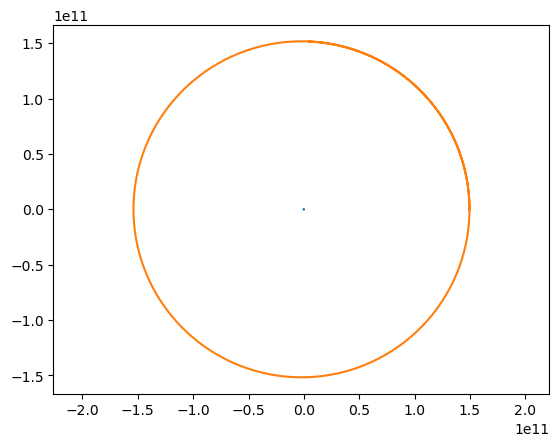

In [26]:
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.axis('equal')

Vamos agora fazer a animação da órbita

In [27]:
# importamos do matplotlib o módulo de animação
# e importamos do Ipython a ferramenta para que a animação possa ser apresentada em HTML e visualizada no navegador
from matplotlib import animation
from IPython.display import HTML

# Quantos frames por segundo a animação deve apresentar
FPS=30  #
#plt.style.use('default')

# Cria o quadro onde a figura será desenhada no matplotlib e pega um ponteiro para o objeto deste quadro.
fig = plt.figure(figsize=(8, 8), dpi=100)

# Modifica os limites da figura para cobrir o quadro inteiro
ax = plt.axes(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))

# Garante que o eixo x e o eixo y possuam a mesma escala
ax.set_aspect('equal')

# remove os eixos que normalmente aparecem
ax.axis('off')

# Define os elementos da animação
terra, = ax.plot([], [], 'bo')  # Cria um ponto para a Terra e pega um ponteiro para o objeto deste ponto
sun, = ax.plot([], [], 'ro')  # Cria um ponto para o Sol e pega um ponteiro para o objeto deste ponto
orbit, = ax.plot([], [], 'b')  # Cria uma linha para a órbita da Terra e pega um ponteiro para o objeto desta linha

# Define de quantos em quantos pontos da integração será o intervalo entre os frames.
step = 5  # O primeiro frame será a posição no tempo t[0], o segundo frame será a posição no tempo t[5] ...

# Pega o último valor do tempo para calcular o número de frames total
framesNum = int(len(t)/step)

def animate(j):
    """ Função de animação. Ela será chamada para cada frame
    
    Parameters
    ----------
    j : int
        Número do frame
    """
    # Calcula qual a posição da órbita será usada para o frame j
    # Isto é necessário porque não precisamos plotar todos os instantes de tempo.
    j = step*j
    
    # Em cada frame atualizamos a posição do círculo e da linha.
    # Isso é necessário porque consome mais processamento fazer plots diferentes para cada frame
    sun.set_data(x1[j]/ua, y1[j]/ua)
    terra.set_data(x2[j]/ua, y2[j]/ua)
    
    # Note que para a órbita, plotamos apenas os 100 valores antes do ponto atual, para fazer um rastro da órbita
    orbit.set_data(x2[np.max([0, j-100]):j]/ua, y2[np.max([0, j-100]):j]/ua)

# Cria a animação
anim = animation.FuncAnimation(fig, animate, frames=framesNum, interval=1000/FPS)

plt.close(anim._fig)

# Mostra a animação
# Pode demorar um pouco para aparecer.
HTML(anim.to_html5_video())

/tmp/ipykernel_10752/344350493.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  sun.set_data(x1[j]/ua, y1[j]/ua)
/tmp/ipykernel_10752/344350493.py:48: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  terra.set_data(x2[j]/ua, y2[j]/ua)


Vamos fazer uma nova integração, agora modificando a velocidade inicial da Terra pela metade para ver o movimento elíptico.

In [28]:
z0 = [0, 0, 0, 0, 1*ua, 0, 0, 15000]
z0_corr = corrige_cm(z0, [m1, m2])
t_span=[0, 4e7]
sol = solve_ivp(orbita, t_span, z0_corr, max_step=10000)

In [29]:
t = sol.t
x1 = sol.y[0]
y1 = sol.y[1]
x2 = sol.y[4]
y2 = sol.y[5]

In [30]:
# importamos do matplotlib o módulo de animação
# e importamos do Ipython a ferramenta para que a animação possa ser apresentada em HTML e visualizada no navegador
from matplotlib import animation
from IPython.display import HTML

# Quantos frames por segundo a animação deve apresentar
FPS=30  #
#plt.style.use('default')

# Cria o quadro onde a figura será desenhada no matplotlib e pega um ponteiro para o objeto deste quadro.
fig = plt.figure(figsize=(8, 8), dpi=100)

# Modifica os limites da figura para cobrir o quadro inteiro
ax = plt.axes(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))

# Garante que o eixo x e o eixo y possuam a mesma escala
ax.set_aspect('equal')

# remove os eixos que normalmente aparecem
ax.axis('off')

# Define os elementos da animação
terra, = ax.plot([], [], 'bo')  # Cria um ponto para a Terra e pega um ponteiro para o objeto deste ponto
sun, = ax.plot([], [], 'ro')  # Cria um ponto para o Sol e pega um ponteiro para o objeto deste ponto
orbit, = ax.plot([], [], 'b')  # Cria uma linha para a órbita da Terra e pega um ponteiro para o objeto desta linha

# Define de quantos em quantos pontos da integração será o intervalo entre os frames.
step = 5  # O primeiro frame será a posição no tempo t[0], o segundo frame será a posição no tempo t[5] ...

# Pega o último valor do tempo para calcular o número de frames total
framesNum = int(len(t)/step)

def animate(j):
    """ Função de animação. Ela será chamada para cada frame
    
    Parameters
    ----------
    j : int
        Número do frame
    """
    # Calcula qual a posição da órbita será usada para o frame j
    # Isto é necessário porque não precisamos plotar todos os instantes de tempo.
    j = step*j
    
    # Em cada frame atualizamos a posição do círculo e da linha.
    # Isso é necessário porque consome mais processamento fazer plots diferentes para cada frame
    sun.set_data(x1[j]/ua, y1[j]/ua)
    terra.set_data(x2[j]/ua, y2[j]/ua)
    
    # Note que para a órbita, plotamos apenas os 100 valores antes do ponto atual, para fazer um rastro da órbita
    orbit.set_data(x2[np.max([0, j-100]):j]/ua, y2[np.max([0, j-100]):j]/ua)

# Cria a animação
anim = animation.FuncAnimation(fig, animate, frames=framesNum, interval=1000/FPS)

plt.close(anim._fig)

# Mostra a animação
# Pode demorar um pouco para aparecer.
HTML(anim.to_html5_video())

/tmp/ipykernel_10752/344350493.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  sun.set_data(x1[j]/ua, y1[j]/ua)
/tmp/ipykernel_10752/344350493.py:48: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  terra.set_data(x2[j]/ua, y2[j]/ua)
